# Business Problem

Description of the problem from the following website: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/ 

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

For the following notebook, I used data science methods to create a model that would be able to predict which water pumps could be accurately classified as "functional", "not functional", or "in need of repair". I used the OSEMN method to the best of my ability and chose the model with the highest accuracy score. 

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from helper import explore_column, model_helper


In [2]:
# explore_column(df, "status_group")

# Obtain

In [3]:
# Obtained two csv files for target variable and features. Merged the dataframes. 
target_df = pd.read_csv("training_set_labels.csv")
features_df = pd.read_csv("training_set_values.csv")
df = pd.merge(target_df, features_df, on="id")
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# View dataframe statistics
# There are only 9 numerical columns. In light of this information, will make a vanilla model with only numerical 
# columns then add in categorical columns to see if that improves the results
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [5]:
# 40 variables that appear to be mostly string datatypes. A lot of the columns look like they could have similar information, 
# such as the three columns, "extraction_type", "extraction_type_group", and "extraction_type_class". They all have the same
# description as well, "The kind of extraction the waterpoint uses". Will look at getting rid of columns that are non needed 
# or are redundant. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [6]:
# Using a bar chart to view the distribution of the target variable, "status_group". With there being three potential outcomes,
# this graph show that this is a multiclass classification problem that is imbalanced

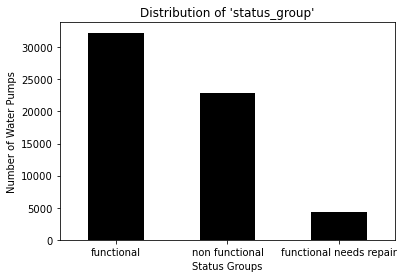

In [7]:
# View distribution of the "status_group" values
df['status_group'].value_counts().plot(kind='bar', color = "black")
      
# giving title to the plot
plt.title("Distribution of 'status_group'")
      
# giving X and Y labels
plt.xlabel("Status Groups")
plt.xticks(rotation = 0)
plt.ylabel("Number of Water Pumps")

plt.show()

In [8]:
# The percentage of "functional needs repair" is very low compared to the other two options. Since
# there are so few, I'm going to drop those values from the status_group column in order to solve the class
# imbalance problem
df['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
# Dropping "functional needs repair"
df = df[df.status_group != "functional needs repair"]

In [10]:
# Confirming the drop
df['status_group'].value_counts(normalize=True)

functional        0.585643
non functional    0.414357
Name: status_group, dtype: float64

# Scrub/Explore

In [11]:
# For the first vanilla model, I'll use the numerical columns from the dataset.
# I'll approach this problem by using a forward selection method, but for that, I'll first use the 
# numerical columns and add features from there. 

In [12]:
# Numerical columns
numerical_columns = df.select_dtypes("number")
numerical_columns.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010


In [13]:
# Next step after trying the vanilla decision tree model and the random forest model, 
# use the models to decide on feature importance for the next categorical feature.
# Based off the two models, the features that were most important were geographical, so
# my next categorical feature will be on that is geographical. In the dataset, there are a few
# that fit that description, "basin", "subvillage", "region", "lga", "ward". I'll take a look at
# the content of each column to make my decision for the next feature

In [14]:
# Explore the "basin", "subvillage", "region", "region", "lga" columns

In [15]:
explore_column(df, "basin")

null values
0

value counts
Lake Victoria              9259
Pangani                    8463
Rufiji                     7539
Internal                   7228
Wami / Ruvu                5718
Lake Tanganyika            5690
Lake Nyasa                 4835
Ruvuma / Southern Coast    4167
Lake Rukwa                 2184
Name: basin, dtype: int64

number of unique values
9

descriptive statistics
count             55083
unique                9
top       Lake Victoria
freq               9259
Name: basin, dtype: object


In [16]:
explore_column(df, "subvillage")

null values
370

value counts
Majengo             466
Madukani            465
Shuleni             462
Kati                330
Mtakuja             248
                   ... 
Murulama Ya Kati      1
Kijangara             1
Vuge                  1
Kasure                1
Kikatanyemba          1
Name: subvillage, Length: 18482, dtype: int64

number of unique values
18482

descriptive statistics
count       54713
unique      18482
top       Majengo
freq          466
Name: subvillage, dtype: object


In [17]:
explore_column(df, "region")

null values
0

value counts
Iringa           5171
Shinyanga        4347
Mbeya            4135
Kilimanjaro      4057
Morogoro         3706
Arusha           3175
Kagera           3012
Mwanza           2919
Pwani            2599
Ruvuma           2476
Tanga            2474
Kigoma           2213
Dodoma           1992
Singida          1965
Tabora           1914
Mara             1909
Rukwa            1673
Mtwara           1604
Manyara          1487
Lindi            1453
Dar es Salaam     802
Name: region, dtype: int64

number of unique values
21

descriptive statistics
count      55083
unique        21
top       Iringa
freq        5171
Name: region, dtype: object


In [18]:
explore_column(df, "lga")

null values
0

value counts
Njombe          2409
Arusha Rural    1204
Moshi Rural     1132
Kilosa          1021
Bagamoyo         995
                ... 
Songea Urban      77
Kigoma Urban      63
Arusha Urban      56
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

number of unique values
125

descriptive statistics
count      55083
unique       125
top       Njombe
freq        2409
Name: lga, dtype: object


In [19]:
explore_column(df, "ward")

null values
0

value counts
Igosi        307
Imalinyi     249
Siha Kati    230
Mdandu       218
Kitunda      203
            ... 
Ifinga         1
Simbay         1
Matarawe       1
Igogo          1
Kinungu        1
Name: ward, Length: 2090, dtype: int64

number of unique values
2090

descriptive statistics
count     55083
unique     2090
top       Igosi
freq        307
Name: ward, dtype: object


### Adding "basin" column

In [20]:
# Based of the number of unique values per column, my second categorical choice for a column
# will be "basin".

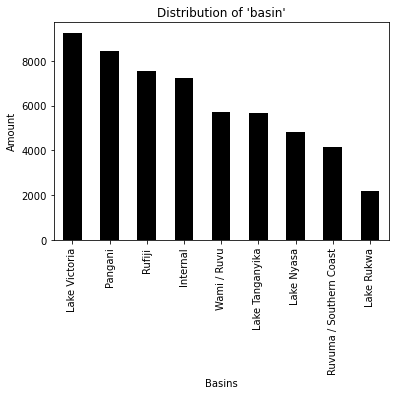

In [21]:
# Graph to show distribution of "basin" values
df['basin'].value_counts().plot(kind='bar', color = "black")

# giving title to the plot
plt.title("Distribution of 'basin'")
      
# giving X and Y labels
plt.xlabel("Basins")
plt.ylabel("Amount")

plt.show()

In [22]:
# Check for missing values
df["basin"].isnull().sum()

0

In [23]:
# Add "basin" column
df_basin = pd.concat([numerical_columns, df['basin']], axis=1)
df_basin.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,Lake Nyasa
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,Lake Victoria


In [24]:
# Dummy code "basin"
df_dummy_basin = pd.get_dummies(df_basin, drop_first=True)
print('Shape before dummy coding: ', df_basin.shape)
print('Shape after dummy coding: ', df_dummy_basin.shape)

Shape before dummy coding:  (55083, 11)
Shape after dummy coding:  (55083, 18)


In [25]:
# Check dataframe
df_dummy_basin.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,1,0,0,0,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,0,0,0,1,0,0,0,0


In [26]:
# Based of the second iteration of models, it looks like there was slight improvement with the addition of the dummy "basin"
# column. Next step would be to add another geographical categorical column, and from further exploration, "region"
# is the next best choice.

### Adding "region" column

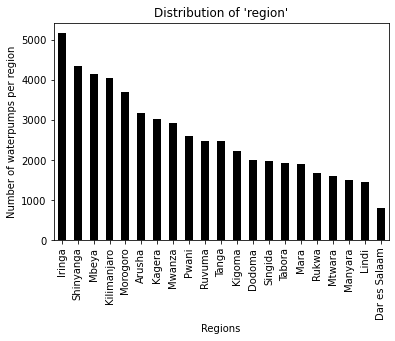

In [27]:
# Graph to show distribution of "region" values 
df['region'].value_counts().plot(kind='bar', color = "black")

# giving title to the plot
plt.title("Distribution of 'region'")
      
# giving X and Y labels
plt.xlabel("Regions")
plt.ylabel("Number of waterpumps per region")

plt.show()

In [28]:
# Add "region" column
df_region = pd.concat([df_dummy_basin, df['region']], axis=1)
df_region.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,1,0,0,0,0,0,0,0,Iringa
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,0,0,0,1,0,0,0,0,Mara


In [29]:
# Dummy code "region"
df_dummy_region = pd.get_dummies(df_region, drop_first=True)

print('Shape before dummy coding: ', df_dummy_basin.shape)

print('Shape after dummy coding: ', df_dummy_region.shape)

Shape before dummy coding:  (55083, 18)
Shape after dummy coding:  (55083, 38)


In [30]:
# Check dataframe
df_dummy_region.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,...,0,0,0,0,0,0,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,...,0,0,0,0,0,0,0,0,0,0


#### Fourth iteration of models

In [31]:
# View original dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55083 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     55083 non-null  int64  
 1   status_group           55083 non-null  object 
 2   amount_tsh             55083 non-null  float64
 3   date_recorded          55083 non-null  object 
 4   funder                 51885 non-null  object 
 5   gps_height             55083 non-null  int64  
 6   installer              51868 non-null  object 
 7   longitude              55083 non-null  float64
 8   latitude               55083 non-null  float64
 9   wpt_name               55083 non-null  object 
 10  num_private            55083 non-null  int64  
 11  basin                  55083 non-null  object 
 12  subvillage             54713 non-null  object 
 13  region                 55083 non-null  object 
 14  region_code            55083 non-null  int64  
 15  di

In [32]:
explore_column(df, "water_quality")

null values
0

value counts
soft                  46914
salty                  4631
unknown                1841
milky                   790
coloured                436
salty abandoned         267
fluoride                187
fluoride abandoned       17
Name: water_quality, dtype: int64

number of unique values
8

descriptive statistics
count     55083
unique        8
top        soft
freq      46914
Name: water_quality, dtype: object


In [33]:
explore_column(df, "quality_group")

null values
0

value counts
good        46914
salty        4898
unknown      1841
milky         790
colored       436
fluoride      204
Name: quality_group, dtype: int64

number of unique values
6

descriptive statistics
count     55083
unique        6
top        good
freq      46914
Name: quality_group, dtype: object


### Adding "quality_group" column 

In [34]:
# Next step will be to add another categorical variable. I'll be adding "quality_group" to the dataframe.

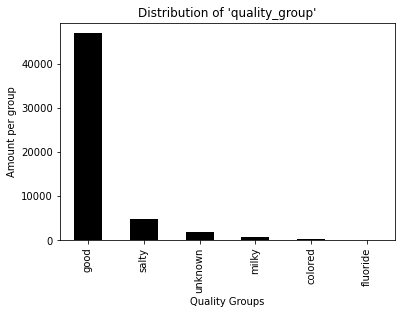

In [35]:
# Graph to show distribution of "basin" values 
df['quality_group'].value_counts().plot(kind='bar', color = "black")

# giving title to the plot
plt.title("Distribution of 'quality_group'")
      
# giving X and Y labels
plt.xlabel("Quality Groups")
plt.ylabel("Amount per group")

plt.show()

In [36]:
# Add "quality_group" column
df_quality_group = pd.concat([df_dummy_region, df["quality_group"]], axis=1)
df_quality_group.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,quality_group
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,...,0,0,0,0,0,0,0,0,0,good
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,...,0,0,0,0,0,0,0,0,0,good


In [37]:
# Dummy code "quality_group"
df_dummy_quality_group = pd.get_dummies(df_quality_group, drop_first=True)

print('Shape before dummy coding: ', df_dummy_region.shape)
print('Shape after dummy coding: ', df_dummy_quality_group.shape)

Shape before dummy coding:  (55083, 38)
Shape after dummy coding:  (55083, 43)


In [38]:
df_dummy_quality_group.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,...,0,0,0,0,0,0,1,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,...,0,0,0,0,0,0,1,0,0,0


In [39]:
# For the fifth iteration of the models, I'd like to try a column that focuses on the "extraction_type"

In [40]:
explore_column(df, "extraction_type")

null values
0

value counts
gravity                      24079
nira/tanira                   7513
other                         6224
submersible                   4537
swn 80                        3458
mono                          2736
india mark ii                 2321
afridev                       1728
ksb                           1389
other - rope pump              434
other - swn 81                 222
windmill                       110
india mark iii                  97
other - play pump               84
cemo                            81
walimi                          36
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

number of unique values
18

descriptive statistics
count       55083
unique         18
top       gravity
freq        24079
Name: extraction_type, dtype: object


In [41]:
explore_column(df, "extraction_type_group")

null values
0

value counts
gravity            24079
nira/tanira         7513
other               6224
submersible         5926
swn 80              3458
mono                2736
india mark ii       2321
afridev             1728
rope pump            434
other handpump       344
other motorpump      113
wind-powered         110
india mark iii        97
Name: extraction_type_group, dtype: int64

number of unique values
13

descriptive statistics
count       55083
unique         13
top       gravity
freq        24079
Name: extraction_type_group, dtype: object


In [42]:
explore_column(df, "extraction_type_class")

null values
0

value counts
gravity         24079
handpump        15461
other            6224
submersible      5926
motorpump        2849
rope pump         434
wind-powered      110
Name: extraction_type_class, dtype: int64

number of unique values
7

descriptive statistics
count       55083
unique          7
top       gravity
freq        24079
Name: extraction_type_class, dtype: object


### Adding "extraction_type_class" column

In [43]:
# After a look at the three similar variables, I'll use the "extraction_type_class" as my next categorical column

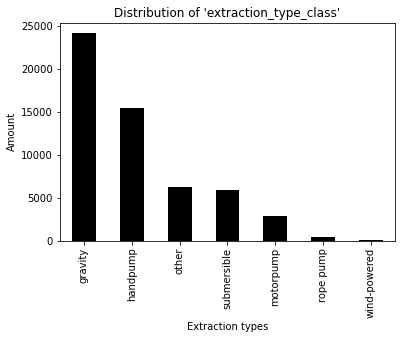

In [44]:
# Graph to show distribution of "basin" values 
df['extraction_type_class'].value_counts().plot(kind='bar', color = "k")

# giving title to the plot
plt.title("Distribution of 'extraction_type_class'")
      
# giving X and Y labels
plt.xlabel("Extraction types")
plt.ylabel("Amount")

plt.show()

In [45]:
# Add "extraction_type_class" column
df_extraction_type_class = pd.concat([df_dummy_quality_group, df["extraction_type_class"]], axis=1)
df_extraction_type_class

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,extraction_type_class
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,...,0,0,0,0,0,1,0,0,0,gravity
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,...,0,0,0,0,0,1,0,0,0,gravity
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,...,0,0,0,0,0,1,0,0,0,gravity
3,67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986,...,0,0,0,0,0,1,0,0,0,submersible
4,19728,0.0,0,31.130847,-1.825359,0,18,1,0,0,...,0,0,0,0,0,1,0,0,0,gravity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,1210,37.169807,-3.253847,0,3,5,125,1999,...,0,0,0,0,0,1,0,0,0,gravity
59396,27263,4700.0,1212,35.249991,-9.070629,0,11,4,56,1996,...,0,0,0,0,0,1,0,0,0,gravity
59397,37057,0.0,0,34.017087,-8.750434,0,12,7,0,0,...,0,0,0,0,1,0,0,0,0,handpump
59398,31282,0.0,0,35.861315,-6.378573,0,1,4,0,0,...,0,0,0,0,0,1,0,0,0,handpump


In [46]:
# Dummy code "extraction_type_class"
df_dummy_extraction_type_class = pd.get_dummies(df_extraction_type_class, drop_first=True)

print('Shape before dummy coding: ', df_dummy_quality_group.shape)
print('Shape after dummy coding: ', df_dummy_extraction_type_class.shape)

Shape before dummy coding:  (55083, 43)
Shape after dummy coding:  (55083, 49)


In [47]:
# Check new dataframe looks as is expected
df_dummy_extraction_type_class.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,...,1,0,0,0,0,0,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,...,1,0,0,0,0,0,0,0,0,0


### Feature engineering the numerical columns "construction_year" and "gps_height"

In [48]:
# Feature Engineering
# For the construction_year and gps_height I used the median of them to replace the 0 values.

### "construction_year"

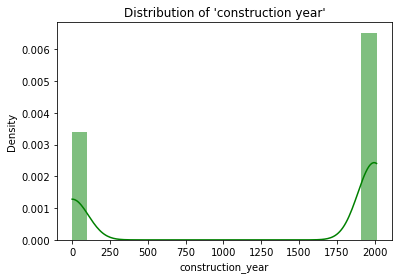

In [49]:
# View the distribution of the column
sns.histplot(numerical_columns['construction_year'], kde=True, stat="density", linewidth=0, color = "g")

# giving title to the plot
plt.title("Distribution of 'construction year'")

plt.show()

In [50]:
explore_column(df, "construction_year")

null values
0

value counts
0       18920
2010     2555
2008     2486
2009     2395
2000     1955
2007     1471
2006     1336
2003     1215
2011     1178
2004     1053
2012     1033
2002     1017
1978      940
1995      939
1999      932
2005      922
1990      895
1998      879
1985      861
1996      763
1980      751
1984      713
1994      695
1982      690
1972      640
1974      637
1992      599
1997      577
1993      574
2001      503
1988      479
1983      467
1986      400
1970      396
1975      396
1976      362
1991      307
1989      302
1987      265
1981      227
1977      192
1979      180
1973      176
2013      175
1971      139
1960       96
1963       79
1968       73
1967       71
1969       56
1964       39
1962       29
1961       18
1965       18
1966       17
Name: construction_year, dtype: int64

number of unique values
55

descriptive statistics
count    55083.000000
mean      1311.016920
std        948.342454
min          0.000000
25%          0.000000
50

In [51]:
# This column has a lot of zeros. I'll replace the zero values with the column median
construction_year_median = numerical_columns['construction_year']
construction_year_median.replace(to_replace = 0, value = construction_year_median.median(), inplace=True)

### "gps_height"

In [52]:
explore_column(df, "gps_height")

null values
0

value counts
 0       18675
-15         59
-13         54
-14         51
-16         51
         ...  
 2278        1
 2484        1
 2264        1
 2133        1
 2366        1
Name: gps_height, Length: 2419, dtype: int64

number of unique values
2419

descriptive statistics
count    55083.000000
mean       671.486230
std        696.404821
min        -90.000000
25%          0.000000
50%        368.000000
75%       1325.000000
max       2628.000000
Name: gps_height, dtype: float64


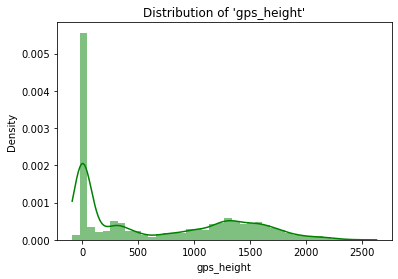

In [53]:
# View the distribution of the column
sns.histplot(numerical_columns['gps_height'], kde=True, stat="density", linewidth=0, color = "g")

# giving title to the plot
plt.title("Distribution of 'gps_height'")

plt.show()

In [54]:
# This column also had a disproportial amount of zeros. I'll also replace the zero values with the column median
gps_height_median = numerical_columns['gps_height']
gps_height_median.replace(to_replace = 0, value = gps_height_median.median(), inplace=True)

In [55]:
# Check zeros have been successfully converted to median 
numerical_columns["gps_height"].value_counts()

 368     18693
-15         59
-13         54
-20         51
-16         51
         ...  
 2278        1
 2484        1
 2264        1
 2133        1
 2366        1
Name: gps_height, Length: 2418, dtype: int64

# Model

## First iteration of models with only numerical columns

In [56]:
# Including only the numerical columns as the X variable for first iteration 
X = numerical_columns.drop("id", axis=1)
y = df["status_group"]

### Fit first logistic regression

In [57]:
lg1 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 1000))

Training Score: 0.6009848863069033
Testing Score: 0.5991649269311065


### Fit first decision tree

In [58]:
dt1 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

Training Score: 0.7368719647801025
Testing Score: 0.7110828719252065
            features  importance
8  construction_year    0.217754
0         amount_tsh    0.196960
3           latitude    0.165300
2          longitude    0.137152
1         gps_height    0.127693
7         population    0.057317
5        region_code    0.055486
6      district_code    0.039735
4        num_private    0.002604


### Fit first random forest

In [59]:
rf1 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

Training Score: 0.7569781691099714
Testing Score: 0.7330489243895797
            features  importance
8  construction_year    0.205276
0         amount_tsh    0.179770
3           latitude    0.152675
2          longitude    0.148269
1         gps_height    0.111983
7         population    0.074190
5        region_code    0.070007
6      district_code    0.052378
4        num_private    0.005451


## Second iteration of models with added categorical column, "basin"

In [60]:
# Add in the new X variable, df_dummy_basin, along with the previous numerical columns
X = df_dummy_basin.drop("id", axis=1)

y = df["status_group"]

### Fit second logistic regression

In [61]:
lg2 = model_helper(X, y, LogisticRegression(random_state=11, max_iter=1000))

Training Score: 0.6093586892388689
Testing Score: 0.6084233457384043


### Fit second decision tree

In [62]:
dt2 = model_helper(X, y, DecisionTreeClassifier(max_depth=10), feature_importance = True)

Training Score: 0.7410021331638905
Testing Score: 0.7137151674684579
                         features  importance
2                       longitude    0.214216
0                      amount_tsh    0.187753
3                        latitude    0.164603
8               construction_year    0.158284
7                      population    0.113768
1                      gps_height    0.075903
5                     region_code    0.038779
6                   district_code    0.025610
9                basin_Lake Nyasa    0.007089
15  basin_Ruvuma / Southern Coast    0.005243
14                   basin_Rufiji    0.004729
4                     num_private    0.002091
16              basin_Wami / Ruvu    0.000967
13                  basin_Pangani    0.000730
10               basin_Lake Rukwa    0.000236
11          basin_Lake Tanganyika    0.000000
12            basin_Lake Victoria    0.000000


### Fit second random forest

In [63]:
rf2 = model_helper(X, y, RandomForestClassifier(max_depth=10), feature_importance = True)

Training Score: 0.7534607180138883
Testing Score: 0.7314150857765271
                         features  importance
0                      amount_tsh    0.182968
8               construction_year    0.182784
3                        latitude    0.141981
2                       longitude    0.140504
1                      gps_height    0.097126
7                      population    0.078518
5                     region_code    0.063940
6                   district_code    0.052436
15  basin_Ruvuma / Southern Coast    0.017648
14                   basin_Rufiji    0.007145
9                basin_Lake Nyasa    0.006911
16              basin_Wami / Ruvu    0.006334
13                  basin_Pangani    0.005797
4                     num_private    0.005528
12            basin_Lake Victoria    0.004623
10               basin_Lake Rukwa    0.002976
11          basin_Lake Tanganyika    0.002782


## Third iteration of models with added dummified categorical column, "region"

In [64]:
# Add in the new X variable, df_dummy_region
X = df_dummy_region.drop("id", axis=1)

y = df["status_group"]

### Fit third logistic regression

In [65]:
lg3 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000))

Training Score: 0.6230654018971543
Testing Score: 0.6225832803848598


C:\Users\Jeff\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Fit third decision tree

In [66]:
dt3 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

Training Score: 0.7322198520401216
Testing Score: 0.7145320867749841
                         features  importance
0                      amount_tsh    0.196819
2                       longitude    0.188412
8               construction_year    0.159218
3                        latitude    0.138003
7                      population    0.121295
1                      gps_height    0.061704
5                     region_code    0.026814
6                   district_code    0.026036
36                   region_Tanga    0.021753
19                  region_Iringa    0.013814
22             region_Kilimanjaro    0.009675
35                  region_Tabora    0.007354
33               region_Shinyanga    0.006307
10               basin_Lake Rukwa    0.005481
25                    region_Mara    0.005140
15  basin_Ruvuma / Southern Coast    0.002975
4                     num_private    0.002834
27                region_Morogoro    0.002791
23                   region_Lindi    0.001277
31         

### Fit third random forest

In [67]:
rf3 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

Training Score: 0.7482185812190805
Testing Score: 0.7315058545883635
                         features  importance
0                      amount_tsh    0.177513
8               construction_year    0.169824
2                       longitude    0.129485
3                        latitude    0.118915
1                      gps_height    0.090098
7                      population    0.080142
6                   district_code    0.050272
5                     region_code    0.042818
19                  region_Iringa    0.028172
15  basin_Ruvuma / Southern Coast    0.014187
23                   region_Lindi    0.008140
28                  region_Mtwara    0.006856
33               region_Shinyanga    0.006702
22             region_Kilimanjaro    0.006545
34                 region_Singida    0.005352
36                   region_Tanga    0.004809
14                   basin_Rufiji    0.004669
9                basin_Lake Nyasa    0.004493
12            basin_Lake Victoria    0.004428
16         

In [68]:
# Based off the feature importances of the highest perform model with the third iteration, it looks like the dummified 
# "region" column made a slight improvement to the test score

## Fourth iteration of models with added dummified categorical column, "quality_group"

In [69]:
# Add in the new X variable, df_dummy_quality_group
X = df_dummy_quality_group.drop("id", axis=1)

y = df["status_group"]

### Fit fourth logistic regression

In [70]:
lg4 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000)) 

Training Score: 0.6350701220895929
Testing Score: 0.636289370972134


### Fit fourth decision tree

In [71]:
dt4 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

Training Score: 0.7366450324513231
Testing Score: 0.7220658981573931
                         features  importance
0                      amount_tsh    0.198194
2                       longitude    0.176369
8               construction_year    0.153783
3                        latitude    0.109172
41          quality_group_unknown    0.071822
7                      population    0.069895
1                      gps_height    0.065888
6                   district_code    0.025896
5                     region_code    0.021287
36                   region_Tanga    0.020767
22             region_Kilimanjaro    0.018023
38             quality_group_good    0.016480
35                  region_Tabora    0.008901
15  basin_Ruvuma / Southern Coast    0.007433
10               basin_Lake Rukwa    0.007206
19                  region_Iringa    0.006391
27                region_Morogoro    0.005043
25                    region_Mara    0.005005
4                     num_private    0.003489
31         

### Fit fourth random forest

In [72]:
rf4 = model_helper(X, y, RandomForestClassifier(max_depth = 10, random_state = 11), feature_importance = True)

Training Score: 0.7434983887804657
Testing Score: 0.7273304892438958
                         features  importance
0                      amount_tsh    0.161785
8               construction_year    0.160321
2                       longitude    0.107929
3                        latitude    0.100059
1                      gps_height    0.079860
41          quality_group_unknown    0.072256
7                      population    0.054447
6                   district_code    0.046036
5                     region_code    0.041619
38             quality_group_good    0.025113
19                  region_Iringa    0.022257
15  basin_Ruvuma / Southern Coast    0.013108
33               region_Shinyanga    0.008956
40            quality_group_salty    0.007990
22             region_Kilimanjaro    0.007630
28                  region_Mtwara    0.007597
23                   region_Lindi    0.006789
31                   region_Rukwa    0.006693
25                    region_Mara    0.006505
9          

## Fifth iteration of models with added dummified categorical column, "quality_group"

In [73]:
# Add in the new X variable, df_dummy_extraction_type
X = df_dummy_extraction_type_class.drop("id", axis=1)

y = df["status_group"]

### Fit fifth logistic regression

In [74]:
lg5 = model_helper(X, y, LogisticRegression(random_state = 11, max_iter = 2000))

Training Score: 0.6893296419007852
Testing Score: 0.6850322229282019


### Fit fifth decision tree

In [75]:
dt5 = model_helper(X, y, DecisionTreeClassifier(max_depth = 10), feature_importance = True)

Training Score: 0.757749739027822
Testing Score: 0.7369519832985386
                              features  importance
44         extraction_type_class_other    0.261221
3                             latitude    0.111472
2                            longitude    0.109078
0                           amount_tsh    0.101870
8                    construction_year    0.101636
1                           gps_height    0.053036
41               quality_group_unknown    0.042068
42      extraction_type_class_handpump    0.039582
7                           population    0.028544
6                        district_code    0.025803
36                        region_Tanga    0.014340
5                          region_code    0.013702
33                    region_Shinyanga    0.013482
25                         region_Mara    0.010608
46   extraction_type_class_submersible    0.008663
15       basin_Ruvuma / Southern Coast    0.007724
34                      region_Singida    0.007464
40            

### Fit fifth random forest

In [76]:
rf5 = model_helper(X, y, RandomForestClassifier(max_depth = 20, random_state = 11), feature_importance = True)

Training Score: 0.9323060863250578
Testing Score: 0.8110193337569211
                              features  importance
2                            longitude    0.176088
3                             latitude    0.173024
8                    construction_year    0.100586
1                           gps_height    0.089929
44         extraction_type_class_other    0.085077
7                           population    0.065250
0                           amount_tsh    0.065060
6                        district_code    0.044865
42      extraction_type_class_handpump    0.027527
5                          region_code    0.024235
41               quality_group_unknown    0.020261
46   extraction_type_class_submersible    0.012965
38                  quality_group_good    0.012614
43     extraction_type_class_motorpump    0.009868
19                       region_Iringa    0.007602
40                 quality_group_salty    0.006515
15       basin_Ruvuma / Southern Coast    0.006268
33           

### Testing fifth random forest model with test values

In [77]:
test_df = pd.read_csv("test_df.csv")
test_df.head(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,...,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,50785,0.0,1996,35.290799,-4.059696,0,21,3,321,2012,...,1,0,0,0,0,0,1,0,0,0
1,51630,0.0,1569,36.656709,-3.309214,0,2,2,300,2000,...,1,0,0,0,0,0,0,0,0,0


In [78]:
my_ids = test_df["id"]
my_ids.head(2)

0    50785
1    51630
Name: id, dtype: int64

In [79]:
test_df.drop("id", axis = 1, inplace = True)

In [80]:
test_df.head(2)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin_Lake Nyasa,...,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,0.0,1996,35.290799,-4.059696,0,21,3,321,2012,0,...,1,0,0,0,0,0,1,0,0,0
1,0.0,1569,36.656709,-3.309214,0,2,2,300,2000,0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
rf_final = model_helper(X, y, RandomForestClassifier(max_depth = 20, random_state = 11), feature_importance = True)

Training Score: 0.9323060863250578
Testing Score: 0.8110193337569211
                              features  importance
2                            longitude    0.176088
3                             latitude    0.173024
8                    construction_year    0.100586
1                           gps_height    0.089929
44         extraction_type_class_other    0.085077
7                           population    0.065250
0                           amount_tsh    0.065060
6                        district_code    0.044865
42      extraction_type_class_handpump    0.027527
5                          region_code    0.024235
41               quality_group_unknown    0.020261
46   extraction_type_class_submersible    0.012965
38                  quality_group_good    0.012614
43     extraction_type_class_motorpump    0.009868
19                       region_Iringa    0.007602
40                 quality_group_salty    0.006515
15       basin_Ruvuma / Southern Coast    0.006268
33           

In [82]:
test_df

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin_Lake Nyasa,...,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
0,0.0,1996,35.290799,-4.059696,0,21,3,321,2012,0,...,1,0,0,0,0,0,1,0,0,0
1,0.0,1569,36.656709,-3.309214,0,2,2,300,2000,0,...,1,0,0,0,0,0,0,0,0,0
2,0.0,1567,34.767863,-5.004344,0,13,2,500,2010,0,...,1,0,0,0,0,0,1,0,0,0
3,0.0,267,38.058046,-9.418672,0,80,43,250,1987,0,...,1,0,0,0,0,0,1,0,0,0
4,500.0,1260,35.006123,-10.950412,0,10,3,60,2000,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.0,34,38.852669,-6.582841,0,6,1,20,1988,0,...,1,0,0,0,0,1,0,0,0,0
14846,1000.0,344,37.451633,-5.350428,0,4,7,2960,1994,0,...,0,0,1,0,1,0,0,0,0,0
14847,0.0,1476,34.739804,-4.585587,0,13,2,200,2010,0,...,1,0,0,0,0,0,0,0,0,0
14848,0.0,998,35.432732,-10.584159,0,10,2,150,2009,1,...,1,0,0,0,0,0,0,0,0,0


In [83]:
rf_final.predict(test_df)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
submission = pd.DataFrame({'id': my_ids, 'status_group': rf5.predict(test_df[X_train.columns])})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

In [ ]:
# View feature importance
feat_import = pd.DataFrame({'features': X_train.columns, 'importance': rf5.feature_importances_})
feat_import.sort_values('importance', ascending=False)

# Interpret

The fifth random forest with the specifications of a max_depth of 20 proved to be the best model for the training set. The 
accuracy on the training score was left at a 0.931 with the testing score left at 0.811. This showed some overfitting on the 
the training set, but the overall testing score was the highest from all the models, so I decided that'd be the best model
to choose. After applying my best model, the fifth random forest, I added it to the competition website and had an overall score of 0.7525 with my current rank being 4,557 out of 14,106 other competitors. 


## Future Work

For future work, I'd be interested in adding more categorical variables and studying how those affect the models. 